In [1]:
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt



In [2]:
import sys
sys.path.append(r"C:\Users\theoh\Desktop\Master Robotics\Cours Obligatoire\Mobile Rob\Projet\EPFL_MoRo_Project") 
import Vision as vis

# Positionnement de la caméra

In [4]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

#cap.release()
#plt.figure()
#plt.imshow(frame)
#plt.show()


while (cap.isOpened()):
    _, frame = cap.read()
    cv2.imshow("results", frame)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

frame 0
frame 1
frame 2
frame 3
frame 4


besoin de prendre plusieurs frame pour éviter l'effet jaune

frame 0
frame 1
frame 2
frame 3
frame 4


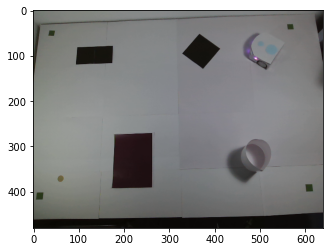

In [3]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    

plt.figure()
plt.imshow(frame)
plt.show()

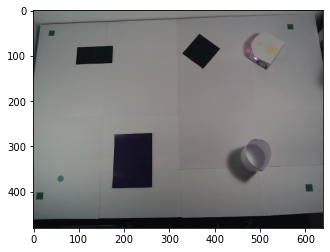

In [4]:

template = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#cv2.imwrite('dessus.png', frame)
plt.figure()
plt.imshow(template)
plt.show()

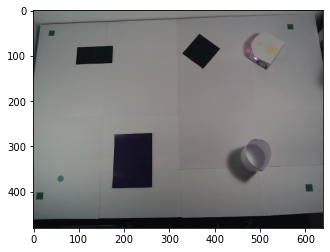

In [5]:
#blurring the picture
blurred = cv2.GaussianBlur(template, (7, 7), 0)
plt.figure()
plt.imshow(template)
plt.show()

## Configuration Mask Green et erode

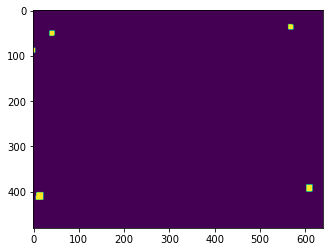

In [6]:
#testing green mask
green_lower=np.array([45,30,30])
green_upper=np.array([90,255,255])


img_hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, green_lower, green_upper)
mask = cv2.erode(mask,None, iterations=4)
mask = cv2.dilate(mask,None, iterations=4)


plt.figure()
plt.imshow(mask)
plt.show()

## Configuration de area size

In [7]:
#Finding the contours

#very important: CHAIN_APPROX_NONE find all contours while simple only finds one
contours,_=cv2.findContours(mask, cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
#trying to draw them
#img_cont=vis.plot_contours(mask, contours, 200, 4)

img_test=blurred.copy()
area_size=50
nb_sides=4
to_be_deleted=[]


#very important to loop backwards
print(len(contours))
initial_length=len(contours)
for i in range(len(contours)) :
    print("i ={}".format(i))
    backwards_i=initial_length-i-1
    print("back_i ={}".format(backwards_i))
    area = cv2.contourArea(contours[backwards_i])
    # Shortlisting the regions based on there area.
    if area < area_size: 
        print("this contour should be supressed {}".format(backwards_i))
        del contours[backwards_i]
 

print(len(contours))




5
i =0
back_i =4
i =1
back_i =3
i =2
back_i =2
this contour should be supressed 2
i =3
back_i =1
i =4
back_i =0
4


4


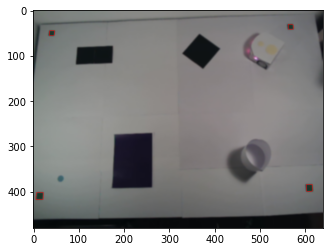

In [8]:
#plotting the resulting contours
cv2.drawContours(img_test, contours, -1, (255, 0, 0),1 )
        
#cv2.imshow('contours on hsv mask', img_test)
print(len(contours))

plt.figure()
plt.imshow(img_test)
plt.show()

In [9]:
#find corners coord
corner_points = []
print(len(contours))
for i in range(len(contours)):
    if (cv2.contourArea(contours[i]) > area_size):
        mom = cv2.moments(contours[i])
        corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés

if len(corner_points) != 4:
    print("failure in identifying corners")

print(corner_points)
        

4
[(14, 409), (609, 391), (41, 50), (568, 36)]


corner x 14 y 409
corner x 609 y 391
corner x 41 y 50
corner x 568 y 36


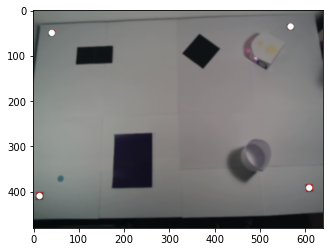

In [10]:
#plot the image with the center on it
# we iterate through each corner, 
# making a circle at each center of corner.
for center in corner_points:
    x, y = center[0], center[1]
    print(f'corner x {x} y {y}')
    cv2.circle(img_test, (x,y), 7, (255, 255, 255), -1)
    #cv2.circle(obsdetect, (x, y), 1, 255, 10)
    
plt.figure()
plt.imshow(img_test)
plt.show()

In [11]:
#ordering the points

#sorting points first by the 2nd the coordinate then 1st coordinate
pts=sorted(corner_points, key=lambda x: (int(x[1]), int(x[0]))) #topleft,topright,bottomleft,bottomright
#vérification du sorting et intervertit si il y a eu une erreur (est necessaire ??)
#top left x > top right x => erreur et intervertit
if pts[0][0] > pts[1][0]:
    pts[0], pts[1] = pts[1], pts[0]
if pts[2][0] > pts[3][0]:
    pts[2], pts[3] = pts[3], pts[2]

for pt in pts:
    x,y=pt[0],pt[1]
    print(f'corner x {x} y {y}')
    
print(pts)

corner_points=pts

corner x 41 y 50
corner x 568 y 36
corner x 14 y 409
corner x 609 y 391
[(41, 50), (568, 36), (14, 409), (609, 391)]


MaxWidth595
maxHeight360
dst[[  0.   0.]
 [594.   0.]
 [  0. 359.]
 [594. 359.]]
corner[[ 41.  50.]
 [568.  36.]
 [ 14. 409.]
 [609. 391.]]
Tranform[[ 1.14386155e+00  8.60285847e-02 -5.11997529e+01]
 [ 3.06173660e-02  1.15252513e+00 -5.88815686e+01]
 [-7.23384944e-07  3.67316776e-04  1.00000000e+00]]


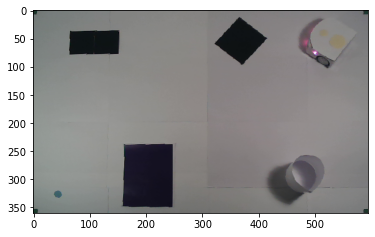

In [12]:
#transformation of the image

(tl, tr, bl, br) = corner_points

#computing width and height
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
print("MaxWidth{}".format(maxWidth))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
print("maxHeight{}".format(maxHeight))

dst = np.array([[0, 0],[maxWidth-1, 0],[0, maxHeight - 1],[maxWidth-1, maxHeight - 1]], dtype = "float32")
print("dst{}".format(dst))
#conversion needed corner points => np.array
corner_points=np.array(corner_points,dtype = "float32")
print("corner{}".format(corner_points))
#computing perspective transform matrix
M = cv2.getPerspectiveTransform(corner_points, dst)

print("Tranform{}".format(M))


final = cv2.warpPerspective(template, M, (maxWidth, maxHeight), cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
#cv2.imwrite('warpped.png',final)
plt.figure()
plt.imshow(final)
plt.show()

## Start Goal and Obstacle Test

frame 0
frame 1
frame 2
frame 3
frame 4


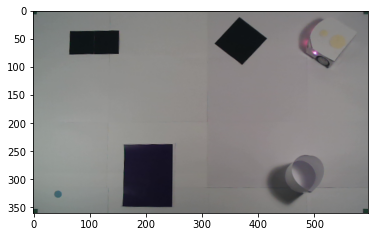

In [13]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(frame)
img=vis.img_calibration(frame,corner_coord)


    
plt.figure()
plt.imshow(img)
plt.show()

## Vérifier les ranges des couleurs

In [14]:
def detectCircle(imgRGB,target):
    coord = []
    color_infos = (0,255,255)
    
    if target == 'thymio':
        coord = []
        lower=np.array([10,40,40])
        upper=np.array([40,255,255])
    if target == 'goal':
        coord = [0,0]
        lower=np.array([170,50,50])
        upper=np.array([240,255,255])
    if target == 'start':
        coord = [0,0]
        lower=np.array([80,50,50])
        upper=np.array([100,255,255])
    
    img_hsv = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, lower, upper)
    img_hsv = cv2.blur(img_hsv,(7,7))
    mask = cv2.erode(mask, None, iterations = 4)
    mask = cv2.dilate(mask, None, iterations = 4)
    #image2 = cv2.bitwise_and(imgRGB, imgRGB, mask=mask)
    elements,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(elements) > 0:
        for i in range(0,len(elements)):
            c = elements[i] 
            ((x,y),rayon) = cv2.minEnclosingCircle(c)
            if target == 'thymio':
                coord.append((x,y,rayon))
            else :
                coord = [x,y]
            #if rayon>0:
                #cv2.circle(image2,(int(x),int(y)), int(rayon), color_infos, 2)
    return coord

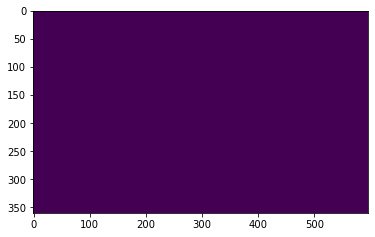

In [15]:
#goal
red_lower=np.array([170,50,50])
red_upper=np.array([240,255,255])

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, red_lower, red_upper)
img_hsv = cv2.blur(img_hsv,(7,7))
mask = cv2.erode(mask, None, iterations = 4)
mask = cv2.dilate(mask, None, iterations = 4)

plt.figure()
plt.imshow(mask)
plt.show()

In [28]:

elements,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(elements) > 0:
    for i in range(0,len(elements)):
        c = elements[i] 
        ((x,y),rayon) = cv2.minEnclosingCircle(c)
        coord = [x,y]
print(coord)

[531.5, 34.0]


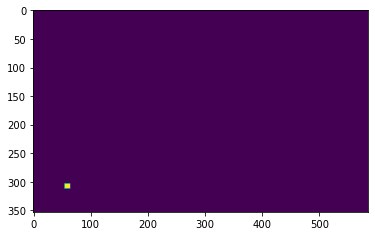

In [29]:
#start
cyan_lower=np.array([80,50,50])
cyan_upper=np.array([120,255,255])

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, cyan_lower, cyan_upper)
img_hsv = cv2.blur(img_hsv,(7,7))
mask = cv2.erode(mask, None, iterations = 4)
mask = cv2.dilate(mask, None, iterations = 4)

plt.figure()
plt.imshow(mask)
plt.show()

In [30]:
elements,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


if len(elements) > 0:
    for i in range(0,len(elements)):
        c = elements[i] 
        ((x,y),rayon) = cv2.minEnclosingCircle(c)
        coord = [x,y]
print(coord)

[59.5, 307.0]


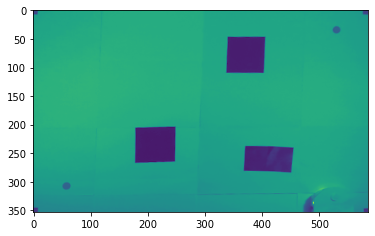

In [31]:
#obstacles

#parameters to tune
area_obst_min=500
area_obst_max=30000
thresh_low=90
thresh_up=255

#img2 grayscale, img rgb to draw contours
img2 = cv2.cvtColor( img , cv2.COLOR_RGB2GRAY)
    
plt.figure()
plt.imshow(img2)
plt.show()

[[(370, 238), (455, 239), (452, 283), (368, 281)], [(178, 206), (248, 203), (249, 264), (178, 267)], [(341, 45), (407, 47), (403, 110), (337, 109)]]


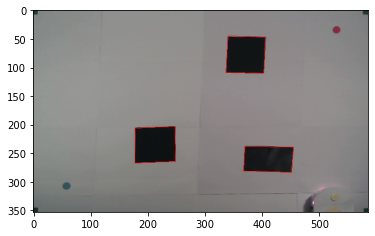

In [32]:

# Converting image to a binary image 
# (black and white only image).
_,threshold = cv2.threshold(img2, thresh_low, thresh_up, 
                                cv2.THRESH_BINARY)
    
# Detecting shapes in image by selecting region 
# with same colors or intensity.
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,
                            cv2.CHAIN_APPROX_SIMPLE)

list_polygon=[]
polygon=[]
# Searching through every region selected to 
# find the required polygon.
for cnt in contours :
    area = cv2.contourArea(cnt)

    # Shortlisting the regions based on there area.
    if area > area_obst_min: 
        if area<area_obst_max:
            approx = cv2.approxPolyDP(cnt, 
                                    0.009 * cv2.arcLength(cnt, True), True)

            # Checking if the no. of sides of the selected region is 7.
            if(len(approx) == 4): 
                cv2.drawContours(img, [approx], 0, (255, 0, 0), 1)
                for i in range (len(approx)):
                    point=(approx[i][0][0],approx[i][0][1])
                    polygon.append(point)
                list_polygon.append(polygon)
                polygon=[]      

print(list_polygon)

#img2 = cv2.cvtColor( img , cv2.COLOR_GRAY2RGB)
plt.figure()
plt.imshow(img)
plt.show()

## Detection Thymio

### application du mask jaune

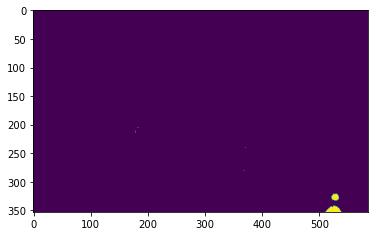

In [33]:
yellow_lower=np.array([10,40,40])
yellow_upper=np.array([40,255,255])

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, yellow_lower, yellow_upper)
img_hsv = cv2.blur(img_hsv,(7,7))
mask = cv2.erode(mask, None, iterations = 0)
mask = cv2.dilate(mask, None, iterations = 0)

plt.figure()
plt.imshow(mask)
plt.show()

### identifie les contours des cercles

12
[106.01923370361328, 236.57691955566406]
[84.5, 218.5]


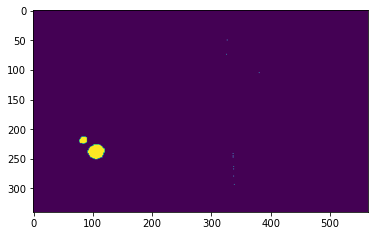

In [14]:
#elements,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
elements,_=cv2.findContours(mask, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

print(len(elements))

target='thymio'
coord=[]

if len(elements) > 0:

    #sorting the detected contours by descending area size
    elements.sort(key=cv2.contourArea, reverse=True)
    #finding big circle
    c=elements[0]
    ((x,y),rayon) = cv2.minEnclosingCircle(c)
    #finding little circle
    c2=elements[1]
    ((x2,y2),rayon2) = cv2.minEnclosingCircle(c2)
    print([x,y])
    print([x2,y2])
    p1=[x,y]
    p2=[x2,y2]
           
plt.figure()
plt.imshow(mask)
plt.show()



### extraire les coordonnées et direction

In [15]:
thymio_coord=vis.detectThymio(img)
print(thymio_coord[0])
print(thymio_coord[1])

[106.01923370361328, 236.57691955566406]
[84.5, 218.5]


In [16]:
def angle_between(pts):
    dist = [pts[1][0]-pts[0][0],pts[1][1]-pts[0][1]]
    #inverse distance en y a cause de l'axe y inversé d'openCV
    dist[1] = -dist[1]
    ang = np.arctan2(dist[1],dist[0])
    return np.rad2deg(ang)

In [17]:
angle=vis.angle_between(thymio_coord)
print(angle)

139.96854928087586


In [18]:
coordThymio = vis.detectThymio(img)
direction = vis.angle_between(coordThymio)
print(coordThymio)
print(direction)

[[106.01923370361328, 236.57691955566406], [84.5, 218.5]]
139.96854928087586


In [19]:
#high level thymio detection 
#for the position calls detectThymio
thymio_coord=vis.detectThymio(img)
#for the direction calls
thym=vis.directionThymio(img)

print(thymio_coord)
print(thym)

[[106.01923370361328, 236.57691955566406], [84.5, 218.5]]
139.96854928087586


## Robust Img Calibration

### Test loop of calibrated img

In [34]:
#resolving the failure in identifying corners problem
#print a message saying unable to identify corners will use the last one provided
#if corner init is empty => fill it

green_lower=np.array([45,30,30])
green_upper=np.array([90,255,255])

#tuning parameters
#corners
iterations_erode=4
area_size=50 #used for corner detections
#obstacles
area_obst_min=500
area_obst_max=30000
thresh_low=90
thresh_up=255



def order_points(pts):
    """
    # initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect
    """
     #sorting points first by the 2nd the coordinate then 1st coordinate
    pts=sorted(pts, key=lambda x: (int(x[1]), int(x[0]))) #topleft,topright,bottomleft,bottomright
    #top left x > top right x => erreur et intervertit
    if pts[0][0] > pts[1][0]:
        pts[0], pts[1] = pts[1], pts[0]
    if pts[2][0] > pts[3][0]:
        pts[2], pts[3] = pts[3], pts[2]
    return pts


def four_point_transform(image, ordered_pts):
	# obtain a consistent order of the points and unpack them
	# individually
    (tl, tr, bl, br) = ordered_pts
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
    #conversion needed corner points => np.array
    ordered_pts=np.array(ordered_pts , dtype = "float32")
    dst = np.array([[0, 0],[maxWidth - 1, 0],[0, maxHeight - 1],[maxWidth - 1, maxHeight - 1]],dtype = "float32")
	# compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(ordered_pts, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
    return warped

def find_corners(img):
    #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_blur = cv2.GaussianBlur(img, (7, 7), 0)
    HSV = cv2.cvtColor(img_blur, cv2.COLOR_RGB2HSV)
    mask=cv2.inRange(HSV,green_lower,green_upper)
    mask = cv2.erode(mask,None, iterations=iterations_erode)
    mask = cv2.dilate(mask,None, iterations=iterations_erode)
    #trouve les contours des coins
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    #suppressing false corners
    initial_length=len(contours)
    for i in range(len(contours)):
        backwards_i=initial_length-i-1
        area = cv2.contourArea(contours[backwards_i])
        # Shortlisting the regions based on there area.
        if area < area_size:
            del contours[backwards_i]
    #finding corners center
    corner_points = []
    for i in range(len(contours)):
        if (cv2.contourArea(contours[i]) > area_size):
            mom = cv2.moments(contours[i])
            corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés
    if len(corner_points) != 4:
        print("failure in identifying corners")
        #corner_points=corner_init
    corner_points=order_points(corner_points)
    return corner_points

def img_calibration(img,corner_coord):
    #input img doit etre en rgb
    #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_blur = cv2.GaussianBlur(img, (7, 7), 0)
    HSV = cv2.cvtColor(img_blur, cv2.COLOR_RGB2HSV)
    mask=cv2.inRange(HSV,green_lower,green_upper)
    mask = cv2.erode(mask,None, iterations=iterations_erode)
    mask = cv2.dilate(mask,None, iterations=iterations_erode)
    #trouve les contours des coins
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    #suppressing false corners
    initial_length=len(contours)
    for i in range(len(contours)):
        backwards_i=initial_length-i-1
        area = cv2.contourArea(contours[backwards_i])
        # Shortlisting the regions based on there area.
        if area < area_size:
            del contours[backwards_i]
    #finding corners center
    corner_points = []
    for i in range(len(contours)):
        if (cv2.contourArea(contours[i]) > area_size):
            mom = cv2.moments(contours[i])
            corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés
    if len(corner_points) != 4:
        print("failure in identifying corners")
        corner_points=corner_coord
    corner_points=order_points(corner_points)
    warpedimg=four_point_transform(img,corner_points)
    
    return warpedimg

In [35]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

state=0

while (cap.isOpened()):
    _, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if(state==0):
        corner_coord=vis.find_corners(img)
        state=1
    if(state==1):
        final=vis.img_calibration(img,corner_coord)
        cv2.imshow("results", final)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

frame 0
frame 1
frame 2
frame 3
frame 4
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners

# Code Complets

frame 0
frame 1
frame 2
frame 3
frame 4


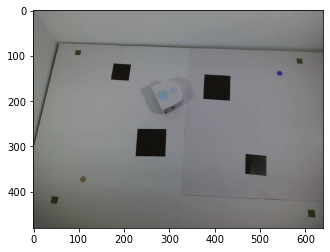

In [14]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

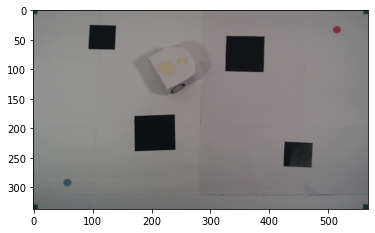

In [15]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

useful other things

In [ ]:
def videoInit(): 
    # 1. Create an object. Zero for external camera
    video = cv2.VideoCapture(0)
    return video

In [ ]:
def takePicture(video): 
    check, frame = video.read()
    
    #print(frame) 
    
    return frame

In [ ]:
img = takePicture(video)
cv2.imwrite('map.png', img)

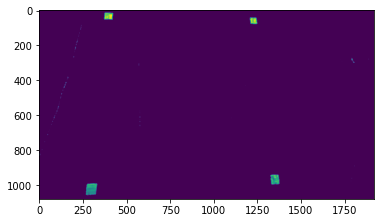

In [86]:
imgRGB = cv2.cvtColor(HSV_blur, cv2.COLOR_HSV2RGB)
imgray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
plt.imshow(imgray)

In [87]:
imgRGB = cv2.cvtColor(output_hsv, cv2.COLOR_HSV2RGB)
imgray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(imgray, 110, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours)

[array([[[328, 992]]], dtype=int32), array([[[318, 992]]], dtype=int32), array([[[310, 992]],

       [[315, 992]]], dtype=int32), array([[[308, 992]]], dtype=int32), array([[[306, 992]]], dtype=int32), array([[[304, 992]]], dtype=int32), array([[[1372,  945]]], dtype=int32), array([[[578, 627]]], dtype=int32), array([[[578, 614]]], dtype=int32), array([[[578, 612]]], dtype=int32), array([[[578, 610]]], dtype=int32), array([[[578, 608]]], dtype=int32), array([[[578, 587]]], dtype=int32), array([[[154, 413]]], dtype=int32), array([[[1804,  298]],

       [[1805,  299]],

       [[1806,  298]],

       [[1805,  299]]], dtype=int32), array([[[1247,   58]],

       [[1247,   60]]], dtype=int32), array([[[1246,   51]]], dtype=int32), array([[[421,  50]],

       [[421,  52]]], dtype=int32), array([[[1245,   47]]], dtype=int32), array([[[421,  44]]], dtype=int32), array([[[374,  44]]], dtype=int32), array([[[374,  42]]], dtype=int32), array([[[374,  40]]], dtype=int32), array([[[423,  28]]],

In [4]:
img = imap.copy()
for cnt in contours :
    area = cv2.contourArea(cnt)
   
    # Shortlisting the regions based on there area.
    if area > 2: 
        print('a')
        approx = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
        print(approx)
   
        # Checking if the no. of sides of the selected region is 7.
        if(len(approx) == 4): 
            cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)
        
plt.imshow(img)

NameError: name 'contours' is not defined

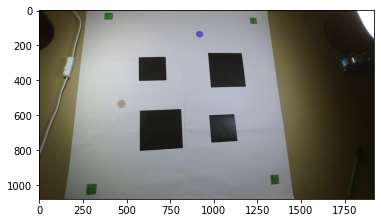

In [7]:
img = cv2.imread('map.png')

cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cimg = cv2.medianBlur(cimg,5)
circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=150)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
plt.imshow(img)

In [26]:
green_lower=np.array([30,50,50])
green_upper=np.array([80,255,255])

red_lower=np.array([150,50,50])
red_upper=np.array([200,255,255])

def order_points(pts):
    """
    # initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect
    """
     #sorting points first by the 2nd the coordinate then 1st coordinate
    pts=sorted(pts, key=lambda x: (int(x[1]), int(x[0]))) #topleft,topright,bottomleft,bottomright
    #vérification du sorting et intervertit si il y a eu une erreur
    #top left x > top right x => erreur et intervertit
    if pts[0][0] > pts[1][0]:
        pts[0], pts[1] = pts[1], pts[0]
    if pts[2][0] > pts[3][0]:
        pts[2], pts[3] = pts[3], pts[2]
    return pts


def four_point_transform(image, ordered_pts):	# obtain a consistent order of the points and unpack them
	# individually
	(tl, tr, br, bl) = ordered_pts
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(ordered_pts, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def img_calibration(img):
    #input img doit etre en rgb
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #applique flou gaussien pour que les contours soit moins durs
    HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
    #a voir si on utilise une autre couleur
    green_mask=cv2.inRange(HSV_blur,green_lower,green_upper)
    #green_mask[70:350,:]=0 #remove the yellow which is similar to green corners
    #green_mask[:,100:500]=0 #remove the yellow which is similar to green corners
    #maskedimg = img.copy()
    #maskedimg[np.where(green_mask==0)] = 0
    
    # Identifier les coins et leurs coordonnées
    #trouve les contours des coins
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    corner_points = []
    for i in range(len(contours)):
        if (cv2.contourArea(contours[i]) > 200):
            mom = cv2.moments(contours[i])
            corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés
       

    if len(corner_points) != 4:
        print("failure in identifying corners")
        print(corner_points)
    corner_points=order_points(corner_points)
    #warpedimg=four_point_transform(img,corner_points)
    # Showing the image along with outlined arrow.
    #cv2.imshow('image2', img2) 
    #cv2.imwrite('lignes_red.png', img2)
    for i in contours:
        approx = cv2.approxPolyDP(i,0.009 * cv2.arcLength(i, True), True)
        if(len(approx) == 4): 
            cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)
        
    plt.imshow(img)
    return img



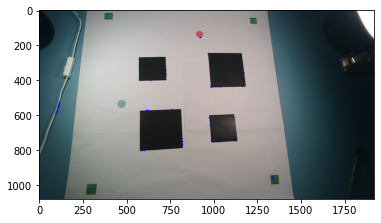

In [27]:
img_wraped = img_calibration(template)